Добрый день! 
Задание по итогам третьего вебинара. 


Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks   
    для обучения модели на губы  
И затем обучить Модель на выбор из segmentation_models_pytorch

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import functional as F
import cv2
from sklearn.model_selection import train_test_split
import time
import  segmentation_models_pytorch as smp

In [145]:
def test_rusult(net,obj):
    sample=obj.next()
    for i in range(4):
        d = sample[0][i:i+1]
        d1= d.cuda()
        a1 = d1[0].cpu()
        a1=a1.permute(1,2,0)
        print(a1.shape)
        plt.imshow(a1)
        plt.show()
        b = sample[1][i]
        b= b.permute(1,2,0)
        print(b.shape)
        plt.imshow(b[:,:,0])
        plt.show()

        r = net(d1)
        r1=r[0]
        r1 = r1.permute(1,2,0)
        r1=r1.cpu()
        r2 = r1.detach()
        r2 = r2.numpy()
        r3 = r2.copy()
        r3[r2>0.5]=1
        r3[r2<=0.5]=0

        print(c.shape)
        plt.imshow(r3[:,:,0])
        plt.show()

In [2]:
# Директория хранения фото
PATH_DATA_PHOTO= r'D:\train\t4\720p'
# Директория хранения масок
PATH_DATA_MASK= r'D:\train\t4\mask'

In [3]:
# Создададим список фалов фото и масок
photo_list = os.listdir(PATH_DATA_PHOTO)
mask_list = os.listdir(PATH_DATA_MASK)

len(photo_list),len(mask_list)

(28594, 28540)

Как видно количесвто фото и масрк различается. Отсавим только те фото, к котрым есть маски

In [4]:
a = photo_list.copy()
for i in a:
    if f'mask{i[5:13]}.png' in mask_list:
        continue
    else:
        photo_list.remove(i)
            
len(photo_list),len(mask_list)        

(28540, 28540)

In [5]:
# сделаем полдные пути
photo_list = [f'{PATH_DATA_PHOTO}/{i}' for i in photo_list]
mask_list = [f'{PATH_DATA_MASK}/{i}' for i in mask_list]

In [6]:
# Оригинальное фото
im= plt.imread(photo_list[10])
im.shape

(720, 1280, 3)

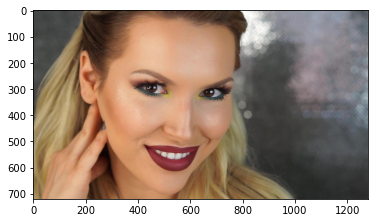

In [7]:
plt.imshow(im)

In [8]:
# Маска оригинального фото 3-х канальная и имеет разные значения
mask_im= plt.imread(mask_list[10])
mask_im.shape

(720, 1280, 3)

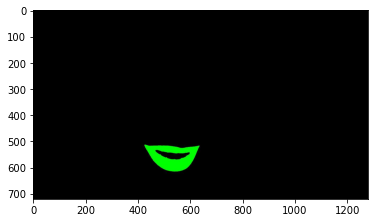

In [9]:
plt.imshow(mask_im)

(720, 1280)


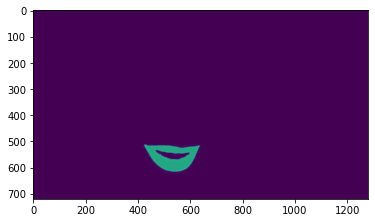

In [12]:
# Сделаем масу одноканальную и выделим явно класс (1) для этого уберем шум, занчения менее 0,1

print(mask_im_one_chanel.shape)
plt.imshow(mask_im_one_chanel)


In [13]:
df = pd.DataFrame()
df['image'] = photo_list
df['mask'] = mask_list
X_train, X_test = train_test_split(df,test_size=0.2,random_state = 5)
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)


In [62]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
#         self.labels = labels
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info['image']
        # и на сегментированные картинки
        self.label_arr = self.data_info['mask']
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info)
        
        # Конвертируем стринговые имена в значения класса на маске
#         self.class_values = list(range(len(labels)))
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        img = Image.open(self.image_arr[index])
        img = img.resize((256,128))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # Количество каналов ставим на первый план - этого хочет pytorch
        img = img.permute(2,0,1).float()
        
        # Считываем нашу маску      
        
        mask_im =  Image.open(self.label_arr[index])
        mask_im = mask_im.resize((256,128))
        mask_im = np.asarray(mask_im)
        if len(mask_im.shape)>2:
            mask_im = mask_im.mean(axis =2)
        mask_im_=mask_im.copy()
        mask1 = (mask_im_>=5).astype(float)
        mask2 = (mask_im_<5).astype(float)
        mask_im_two_chanel = np.stack([mask1,mask2],axis = -1)
        
        mask = torch.as_tensor(mask_im_two_chanel)
        mask = mask.permute(2,0,1).float()
        
        
        return (img, mask)

    def __len__(self):
        return self.data_len

In [63]:
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [64]:
train_data_loader = DataLoader(train_data,batch_size=4,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=4,shuffle=False)

In [65]:
sample = iter(train_data_loader).next()

In [66]:
sample[0].size(),sample[1].size()

(torch.Size([4, 3, 128, 256]), torch.Size([4, 2, 128, 256]))

torch.Size([128, 256, 3])
torch.Size([128, 256, 2])


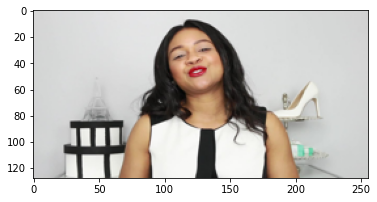

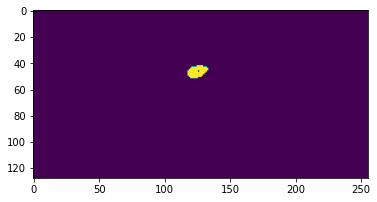

torch.Size([128, 256, 3])
torch.Size([128, 256, 2])


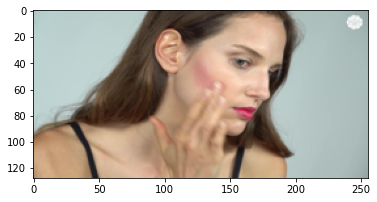

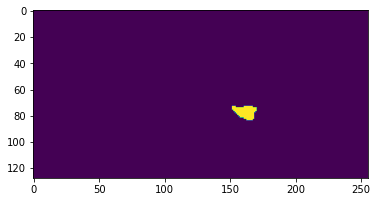

torch.Size([128, 256, 3])
torch.Size([128, 256, 2])


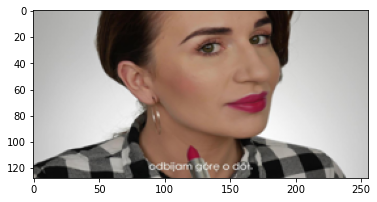

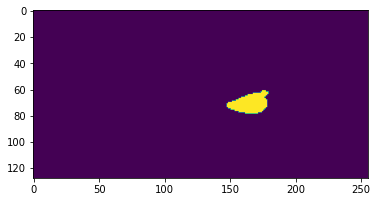

torch.Size([128, 256, 3])
torch.Size([128, 256, 2])


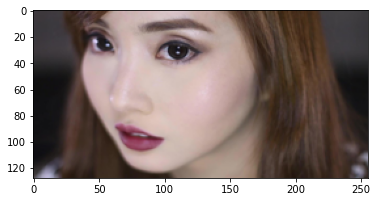

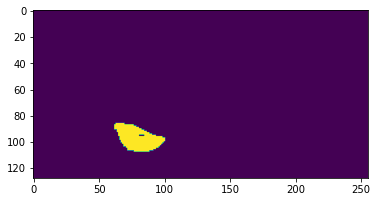

In [67]:
for i in range(4):
    a = sample[0][i]
    a=a.permute(1,2,0)
    print(a.shape)
    b = sample[1][i]
    b= b.permute(1,2,0)
    print(b.shape)
    plt.imshow(a)
    plt.show()
    plt.imshow(b[:,:,0])
    plt.show()

In [68]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [69]:
%%time
segmodel = smp.Unet('resnet34', encoder_weights='imagenet', classes=2, activation='softmax').to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=segmodel.parameters(), lr=0.001),
])

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

max_score = 0

for i in range(0, 3):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './my_best_smp_model_1.pth')
        print('Model saved!')
        
    if i == 2:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
valid: 100%|████████████████████████████| 1427/1427 [03:13<00:00,  7.37it/s, dice_loss - 0.0006765, iou_score - 0.9987]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████| 1427/1427 [02:55<00:00,  8.12it/s, dice_loss - 0.0004153, iou_score - 0.9992]
Model saved!

Epoch: 2
valid: 100%|████████████████████████████| 1427/1427 [03:04<00:00,  7.72it/s, dice_loss - 0.0003063, iou_score - 0.9994]
Model saved!
Decrease decoder learning rate to 1e-5!
Wall time: 1h 16min 28s


In [147]:
sample_obj = iter(test_data_loader)

torch.Size([128, 256, 3])


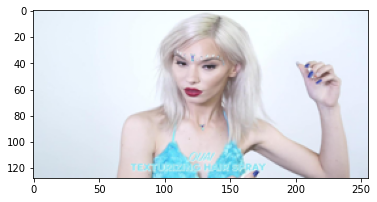

torch.Size([128, 256, 2])


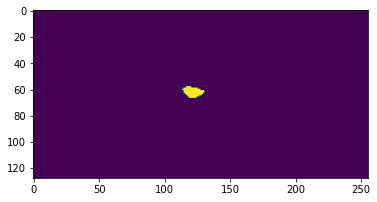

(128, 256, 2)


C:\ProgramData\Anaconda3\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


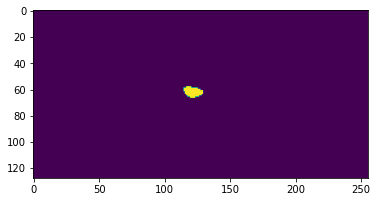

torch.Size([128, 256, 3])


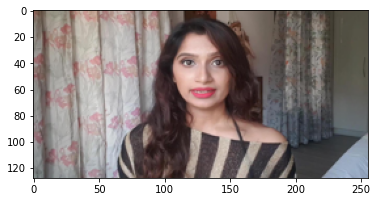

torch.Size([128, 256, 2])


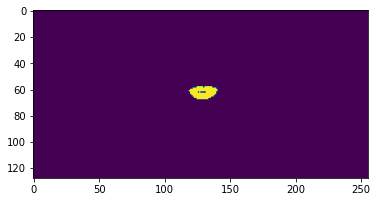

(128, 256, 2)


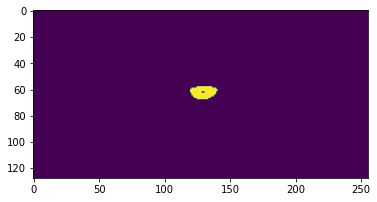

torch.Size([128, 256, 3])


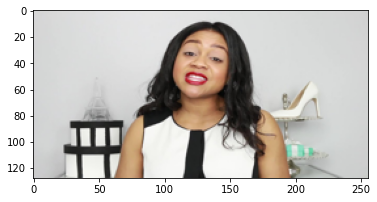

torch.Size([128, 256, 2])


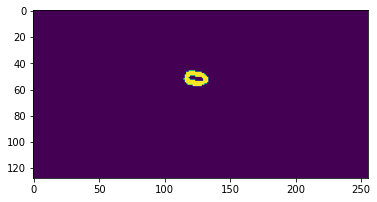

(128, 256, 2)


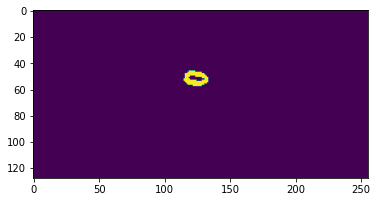

torch.Size([128, 256, 3])


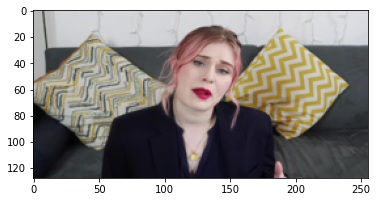

torch.Size([128, 256, 2])


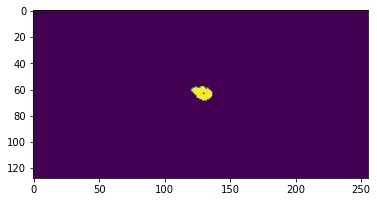

(128, 256, 2)


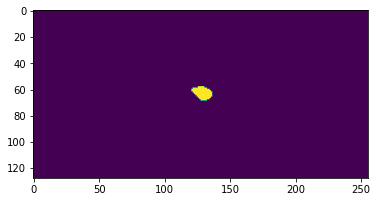

In [148]:
test_rusult(segmodel,sample_obj)

In [70]:
%%time
segmodel_1 = smp.Linknet('resnet34', encoder_weights='imagenet', classes=2, activation='softmax').to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=segmodel_1.parameters(), lr=0.0005),
])

train_epoch = smp.utils.train.TrainEpoch(
    segmodel_1, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel_1, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

max_score = 0

for i in range(0, 3):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './my_best_smp_model_2.pth')
        print('Model saved!')
        
    if i == 2:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|████████████████████████████| 1427/1427 [02:50<00:00,  8.38it/s, dice_loss - 0.0006398, iou_score - 0.9988]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████| 1427/1427 [02:50<00:00,  8.37it/s, dice_loss - 0.0003249, iou_score - 0.9994]
Model saved!

Epoch: 2
valid: 100%|████████████████████████████| 1427/1427 [02:50<00:00,  8.37it/s, dice_loss - 0.0003428, iou_score - 0.9993]
Decrease decoder learning rate to 1e-5!
Wall time: 1h 9min 16s


torch.Size([128, 256, 3])


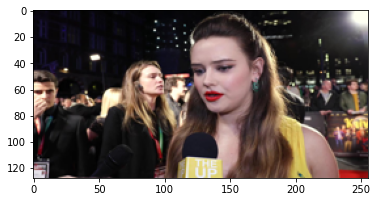

torch.Size([128, 256, 2])


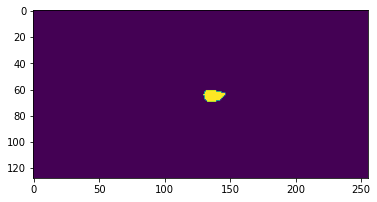

(128, 256, 2)


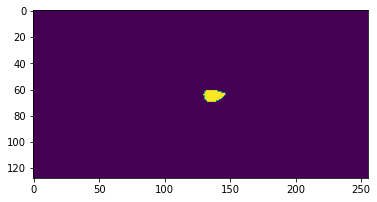

torch.Size([128, 256, 3])


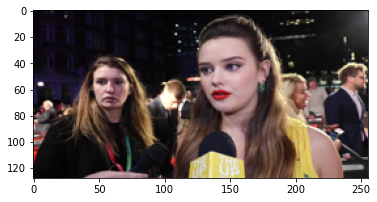

torch.Size([128, 256, 2])


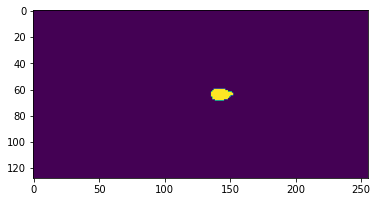

(128, 256, 2)


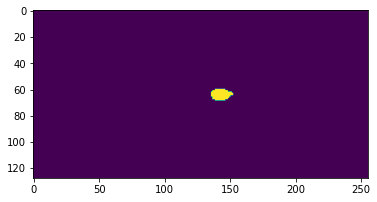

torch.Size([128, 256, 3])


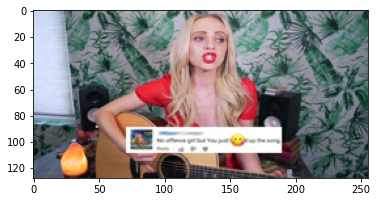

torch.Size([128, 256, 2])


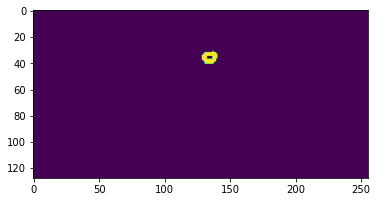

(128, 256, 2)


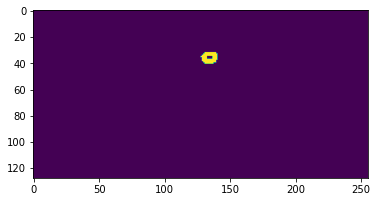

torch.Size([128, 256, 3])


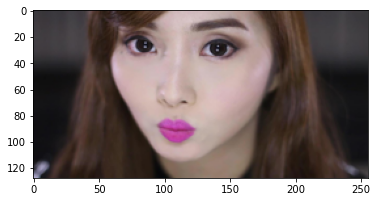

torch.Size([128, 256, 2])


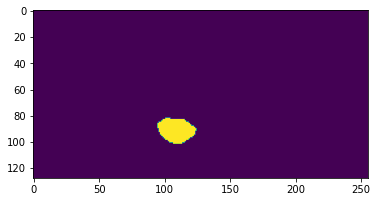

(128, 256, 2)


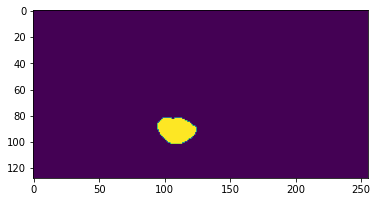

In [149]:
test_rusult(segmodel_1,sample_obj)

In [ ]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,\
                                             kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, \
                                             kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128,\
                                             kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64,\
                                             kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        self.softmax = nn.Softmax()
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels,\
                                        kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels,\
                                              kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
#         y = self.crop_tensor(x, x7)
        
        
        x = self.up_conv_12(torch.cat((x, x7), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
#         y = self.crop_tensor(x, x5)
#         print(x.shape,x5.shape)
        x = self.up_conv_22(torch.cat((x, x5), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
#         y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, x3), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
#         y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, x1), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        output = self.softmax(output)

        return output

In [71]:
learning_rate = 0.001
epochs = 2
Umodel = UNet(num_classes=2).to(device)
optimizer = torch.optim.Adam(Umodel.parameters())

In [72]:
%%time
criterion = smp.utils.losses.DiceLoss()

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
Umodel.train()
for epoch in range(epochs):
    time1 = time.time()
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = data.to(device), labels.to(device)        
        
        optimizer.zero_grad()

        outputs = Umodel(data)
        
        loss = criterion(outputs, labels)
        

        
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx%200==0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    

    
    epoch_losses.append(epoch_loss)


<ipython-input-26-8d41f318ff4f>:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


batch index : 0 | loss : 0.5008589029312134
batch index : 200 | loss : 0.01006990671157837
batch index : 400 | loss : 0.002336859703063965
batch index : 600 | loss : 0.0007523894309997559
batch index : 800 | loss : 0.001177370548248291
batch index : 1000 | loss : 0.0014805197715759277
batch index : 1200 | loss : 0.0017355084419250488
batch index : 1400 | loss : 0.0008596181869506836
batch index : 1600 | loss : 0.0010401010513305664
batch index : 1800 | loss : 0.0009651780128479004
batch index : 2000 | loss : 0.0015940666198730469
batch index : 2200 | loss : 0.0007633566856384277
batch index : 2400 | loss : 0.00029075145721435547
batch index : 2600 | loss : 0.0004407167434692383
batch index : 2800 | loss : 0.00035446882247924805
batch index : 3000 | loss : 0.0002936720848083496
batch index : 3200 | loss : 0.00026422739028930664
batch index : 3400 | loss : 0.0011835694313049316
batch index : 3600 | loss : 0.0005936026573181152
batch index : 3800 | loss : 0.0003897547721862793
batch index

torch.Size([128, 256, 3])


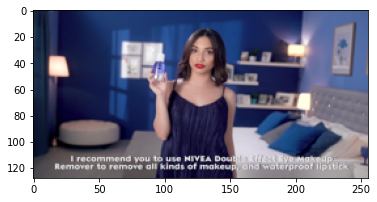

torch.Size([128, 256, 2])


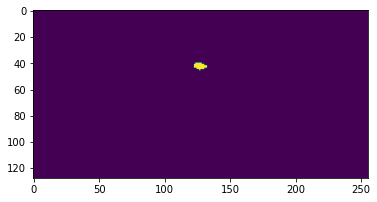

(128, 256, 2)


<ipython-input-26-8d41f318ff4f>:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


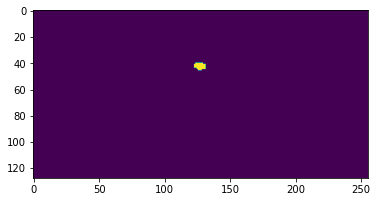

torch.Size([128, 256, 3])


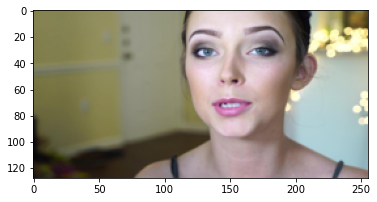

torch.Size([128, 256, 2])


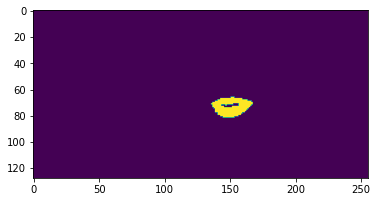

(128, 256, 2)


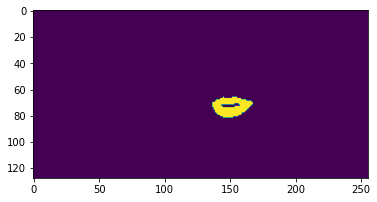

torch.Size([128, 256, 3])


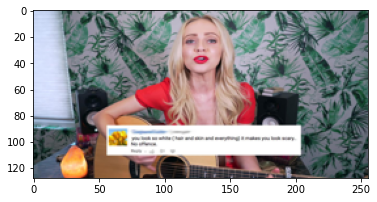

torch.Size([128, 256, 2])


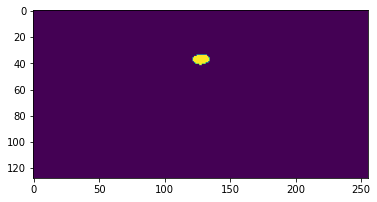

(128, 256, 2)


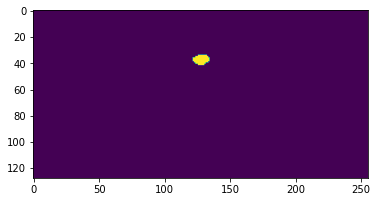

torch.Size([128, 256, 3])


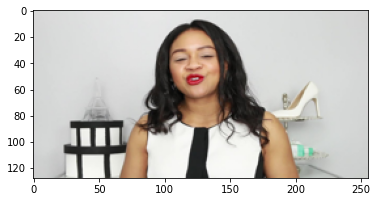

torch.Size([128, 256, 2])


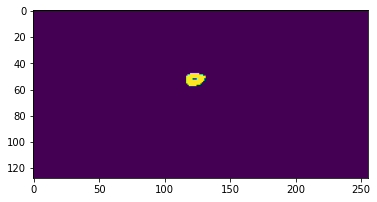

(128, 256, 2)


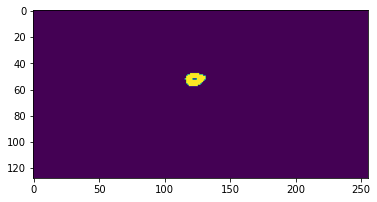

In [144]:
test_rusult(Umodel,sample_obj)

Все модели показали отличные рещультаты